In [2]:
# libraries importing
from numpy import loadtxt
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import pickle
from numpy import random
from random import sample
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
from sklearn.decomposition import PCA
from scipy.stats import ttest_rel

In [3]:
# baseline model
def baseline_model(x):
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [4]:
# reading files
daily_sales_data = pd.read_csv("daily_sales_data.csv")
promotion_dates = pd.read_csv('PromotionDates.csv')
returns = daily_sales_data[daily_sales_data["SalesQuantity"]<0].copy()
daily_sales_data.drop(daily_sales_data[daily_sales_data.SalesQuantity < 0].index, inplace=True)

In [5]:
# date s format changing
daily_sales_data['Date'] = pd.to_datetime(daily_sales_data['Date'], format="%Y-%m-%d")
promotion_dates['StartDate'] = pd.to_datetime(promotion_dates['StartDate'], format="%d/%m/%Y")
promotion_dates['EndDate'] = pd.to_datetime(promotion_dates['EndDate'], format="%d/%m/%Y")
returns['Date'] = pd.to_datetime(returns['Date'], format="%Y-%m-%d")

In [6]:
# creating a array which includes promotion dates as an array. 
starts = promotion_dates["StartDate"].values
ends = promotion_dates["EndDate"].values
periods = promotion_dates["Period"].values
a = []
for index, value in enumerate(starts):
    a.append([starts[index], ends[index], periods[index]])
a = np.array(a)

# get_promo_type2 function to execute if the promo exist for those day.
def get_promo_type2(date, promo_array):
    for i in promo_array:
        if i[0] <= date and date <= i[1]:        
            return "1"
    return "0"

In [7]:
# according to dates, it is used to find 0 ,1 to write to data.
global_promotions = [get_promo_type2(path, a) for path in daily_sales_data['Date'].values]

In [8]:
return_promotions = [get_promo_type2(path, a) for path in returns['Date'].values]
returns['promotion_type'] = return_promotions

In [9]:
daily_sales_data['promotion_type'] = global_promotions
'''no_promotion_sales = daily_sales_data[daily_sales_data["promotion_type"]=='0']
no_promotion_sales[ (no_promotion_sales["ProductCode"]==317)][["Date","SalesQuantity"]]'''
daily_sales_data

,Date,StoreCode,ProductCode,SalesQuantity,promotion_type
1,2015-01-01,131,9,1,0
2,2015-01-01,144,9,2,0
3,2015-01-01,203,9,2,0
4,2015-01-01,256,9,0,0
5,2015-01-01,273,9,1,0
...,...,...,...,...,...
1873613,2015-07-30,292,315,0,0
1873614,2015-07-31,12,315,1,0
1873615,2015-07-31,104,315,1,0
1873616,2015-07-31,261,315,1,0


In [10]:
'''groupped = no_promotion_sales.groupby(['ProductCode','StoreCode',pd.Grouper(freq="W", key='Date')]).sum("SalesQuantity")
groupped=groupped.reset_index()
#groupped = groupped.drop('StoreCode',axis=1)
groupped= groupped.sort_values(by=['StoreCode','Date','ProductCode'], ascending=True)
#groupped.to_csv('2.soru.csv')
groupped'''

'groupped = no_promotion_sales.groupby([\'ProductCode\',\'StoreCode\',pd.Grouper(freq="W", key=\'Date\')]).sum("SalesQuantity")\ngroupped=groupped.reset_index()\n#groupped = groupped.drop(\'StoreCode\',axis=1)\ngroupped= groupped.sort_values(by=[\'StoreCode\',\'Date\',\'ProductCode\'], ascending=True)\n#groupped.to_csv(\'2.soru.csv\')\ngroupped'

In [11]:
'''n_clusters = 3
data_x = groupped
data_x = data_x[["SalesQuantity","ProductCode"]]
data_x
pca = PCA(n_components=2, random_state=1)
pca_result = pca.fit_transform(data_x)

model = KMeans(n_clusters=n_clusters, random_state=0)

model = model.fit(pca_result)
y = model.predict(pca_result)

colors = ['red', 'green', 'blue', 'orange', 'magenta', 'cyan', 'yellow']

plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(pca_result[y == i, 0], pca_result[y == i, 1], s=50,
                c=colors[i], label='Cluster #' + str(i))
plt.scatter(model.cluster_centers_[:, 0],
            model.cluster_centers_[:, 1], s=200, c='black', label='Centroids')
plt.title('KMeans Cluster')
plt.grid()
plt.legend()
plt.show()'''

'n_clusters = 3\ndata_x = groupped\ndata_x = data_x[["SalesQuantity","ProductCode"]]\ndata_x\npca = PCA(n_components=2, random_state=1)\npca_result = pca.fit_transform(data_x)\n\nmodel = KMeans(n_clusters=n_clusters, random_state=0)\n\nmodel = model.fit(pca_result)\ny = model.predict(pca_result)\n\ncolors = [\'red\', \'green\', \'blue\', \'orange\', \'magenta\', \'cyan\', \'yellow\']\n\nplt.figure(figsize=(10, 8))\nfor i in range(n_clusters):\n    plt.scatter(pca_result[y == i, 0], pca_result[y == i, 1], s=50,\n                c=colors[i], label=\'Cluster #\' + str(i))\nplt.scatter(model.cluster_centers_[:, 0],\n            model.cluster_centers_[:, 1], s=200, c=\'black\', label=\'Centroids\')\nplt.title(\'KMeans Cluster\')\nplt.grid()\nplt.legend()\nplt.show()'

In [12]:
'''Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(no_promo_data_x)
    Error.append(kmeans.inertia_)

plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()'''

"Error =[]\nfor i in range(1, 11):\n    kmeans = KMeans(n_clusters = i)\n    kmeans.fit(no_promo_data_x)\n    Error.append(kmeans.inertia_)\n\nplt.plot(range(1, 11), Error)\nplt.title('Elbow method')\nplt.xlabel('No of clusters')\nplt.ylabel('Error')\nplt.show()"

In [13]:
colors = ["green","red"]
def promo_label(is_promoted):
    return "NoPromo" if int(is_promoted) else "Promo"

def plot_aggregated_sales(group_term, time_width,daily_sales_data,code):
    # günlük storelardaki satışların gruplanmış datası
    store = daily_sales_data[daily_sales_data[group_term]==code]
    date_grouped_store = store.groupby(pd.Grouper(freq=time_width, key='Date'))['SalesQuantity'].sum()
    date_grouped_store = pd.DataFrame({'Date':date_grouped_store.index, 'Satis':date_grouped_store.values})

    #
    daily_grouped_promos = [get_promo_type2(path, a) for path in date_grouped_store['Date'].values]
    #sorted_ = store_8.sort_values(by=['Date'], ascending=True)
    date_grouped_store["promotion_type"] = daily_grouped_promos
    #df1['timestamp'] = df1['Date'].apply(lambda x: int(time.mktime(x.date().timetuple())))
    date_grouped_store['timestamp'] = [i for i in range(len(date_grouped_store))]
    

    promoteds = date_grouped_store[date_grouped_store["promotion_type"]=="1"]
    data1 = [promoteds["Satis"].values, promoteds["timestamp"]]

    no_promo = date_grouped_store[date_grouped_store["promotion_type"]=="0"]
    data2 = [no_promo["Satis"].values, no_promo["timestamp"]]

    zipped = [data1,data2]

    fig = plt.figure(figsize=(15, 5))
    for i in range(len(zipped)):
        plt.scatter(zipped[i][1],zipped[i][0] ,label=promo_label(i), color=colors[i])

    plt.title('Daily Sales for {}={}'.format(group_term, code))
    plt.grid()
    plt.xlabel("Days")
    plt.ylabel("SalesQuantity")
    plt.legend()
    plt.show()
        

In [14]:
def plot_store_returns(data,j):
    
    store_8 = data[data['StoreCode']==j]
    df1 = store_8.groupby(pd.Grouper(freq='D', key='Date'))['SalesQuantity'].sum()
    df1 = pd.DataFrame({'Date':df1.index, 'Satis':df1.values})

    daily_grouped_promos = [get_promo_type2(path, a) for path in df1['Date'].values]
    sorted_ = store_8.sort_values(by=['Date'], ascending=True)
    df1["promotion_type"] = daily_grouped_promos
    df1['timestamp'] = df1['Date'].apply(lambda x: int(time.mktime(x.date().timetuple())))
    df1['timestamp'] = [i for i in range(len(df1))]
    
    df1['Satis'] = df1['Satis'].apply(lambda x: -x)
    df1 = df1[df1["Satis"]>0]
    promoss = df1["promotion_type"].values

    promoteds = df1[df1["promotion_type"]=="1"]
    data1 = [promoteds["Satis"].values, promoteds["timestamp"]]

    no_promo = df1[df1["promotion_type"]=="0"]
    data2 = [no_promo["Satis"].values, no_promo["timestamp"]]

    data = [data1,data2]
    
    fig = plt.figure(figsize=(15, 5))
    for i in range(len(data)):
        plt.scatter(data[i][1],data[i][0] ,label=promo_label(i), color=colors[i])

    plt.title('Daily Returns for StoreCode={}'.format(j))
    plt.grid()
    plt.xlabel("Days Timestamp")
    plt.ylabel("Return")
    plt.legend()
    plt.show()

In [15]:
def construct_and_train_model(group_term, time_width,daily_sales_data,code):
    store = daily_sales_data[daily_sales_data[group_term]==code]
    df1 = store_8.groupby(pd.Grouper(freq=time_width, key='Date'))['SalesQuantity'].sum()
    df1 = pd.DataFrame({'Date':df1.index, 'Satis':df1.values})
    daily_grouped_promos = [get_promo_type2(path, a) for path in df1['Date'].values]
    df1["promotion_type"] = daily_grouped_promos
    df1['timestamp'] = [i for i in range(len(df1))]
    X_scaler = MinMaxScaler()
    Y_scaler = MinMaxScaler()
    Y_data = df1['Satis'].values
    X_data = X_scaler.fit_transform(df1[['promotion_type','timestamp']])
    #Y_data2 = Y_scaler.fit_transform(data[['Satis']])
    b = np.array([Y_data])
    Y_data = b.T
    Y_data
    data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(X_data, Y_data, test_size=0.25,random_state=40)
    
    model = Sequential()
    model.add(Dense(32, input_dim=len(data_x_train[0]), kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    #model.compile(loss='mean_squared_error', optimizer='adam')

    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])
    history = model.fit(data_x_train, data_y_train, epochs=200, validation_split=0.2)
    
    y_pred = model.predict(data_x_test)
    #model.evaluate(data_x_test, data_y_test, batch_size=128)
    print(data_y_test,y_pred)
    plt.axes(aspect='equal')
    plt.scatter(data_y_test, y_pred)
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('A plot that shows the true and predicted values')
    plt.xlim([0, 60])
    plt.ylim([0, 60])
    plt.plot([0, 60], [0, 60])
    
    return history

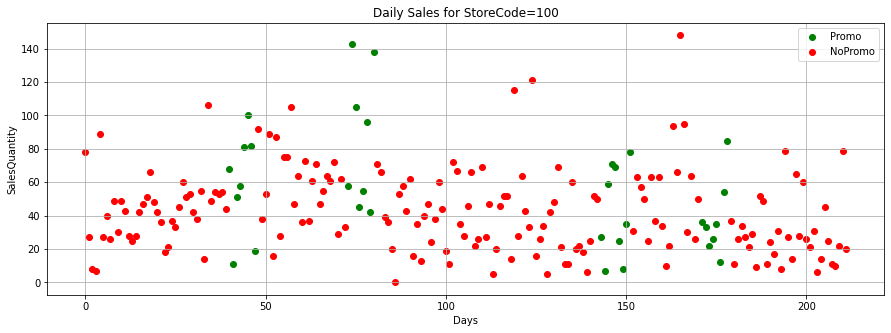

In [18]:
x=random.randint(200, size=(1))
for i in x:
    plot_aggregated_sales("StoreCode","D",daily_sales_data,i)

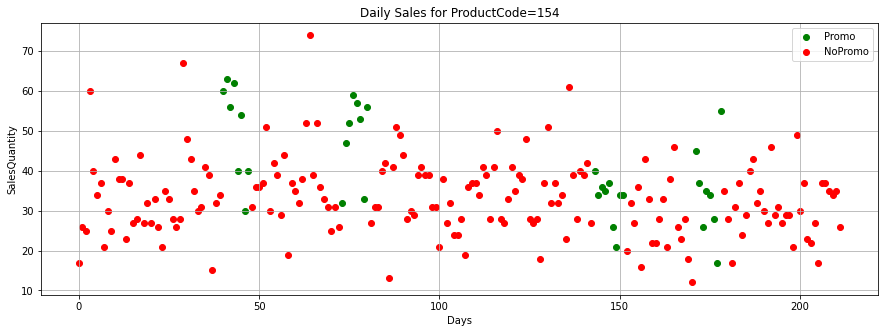

In [19]:
x=random.randint(200, size=(1))
for i in x:
    plot_aggregated_sales("ProductCode","D",daily_sales_data,i)

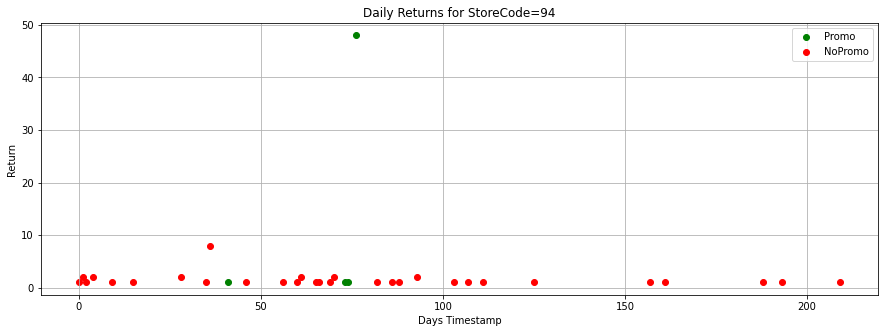

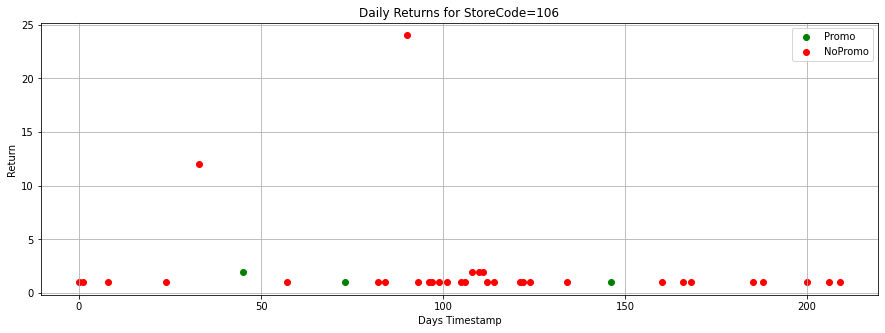

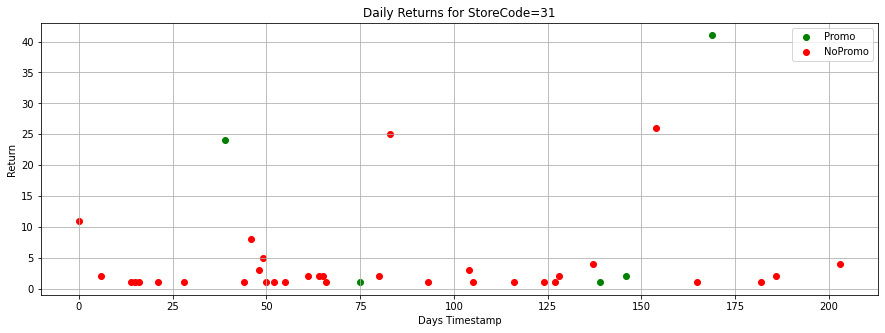

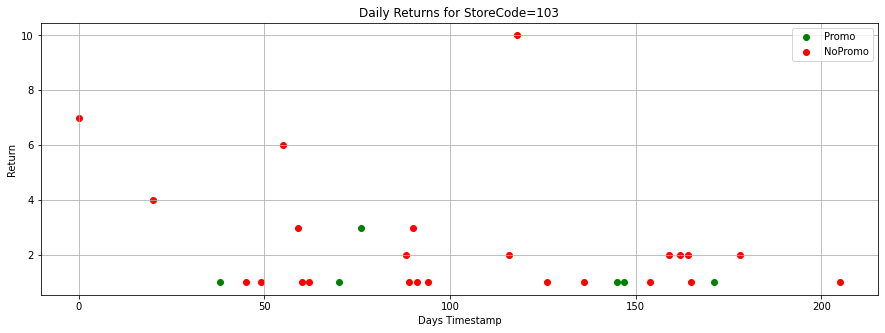

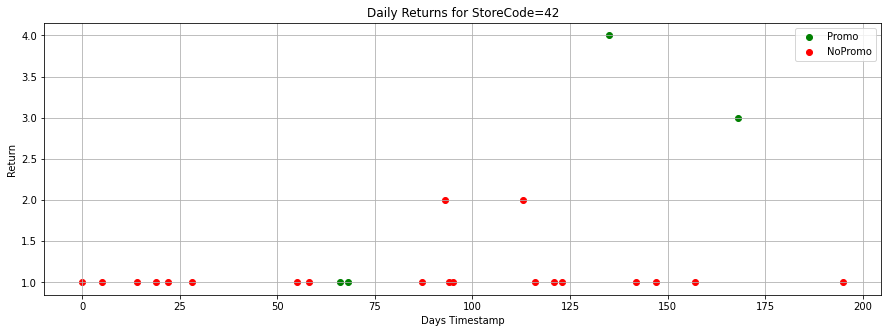

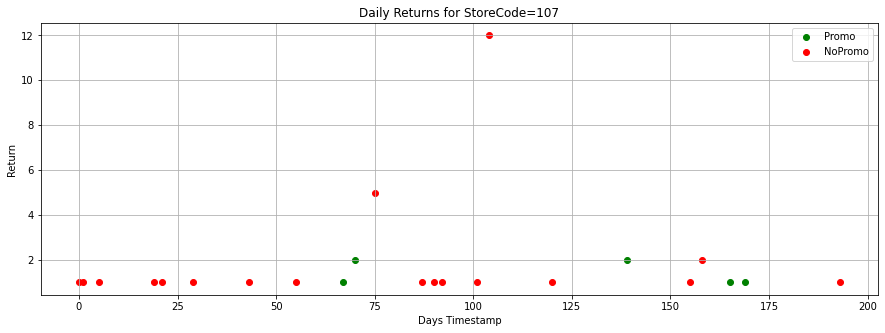

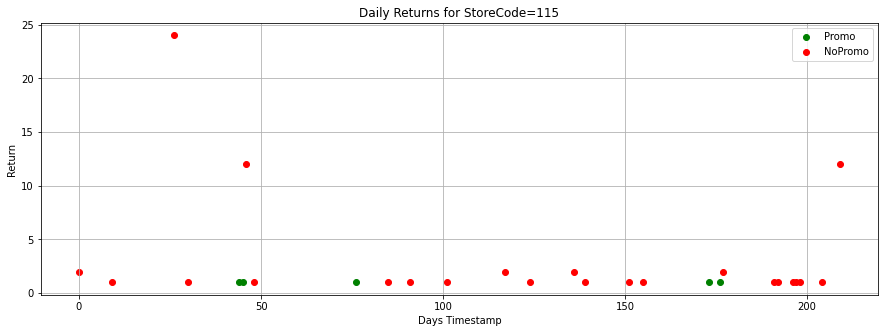

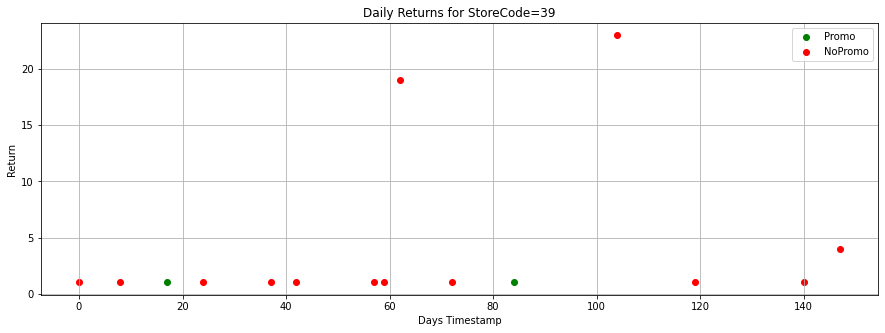

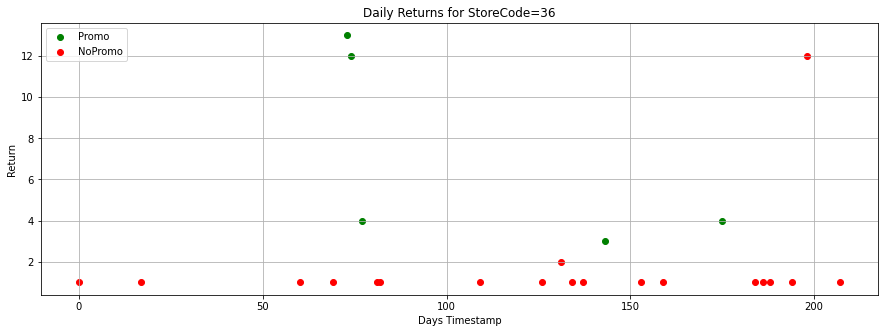

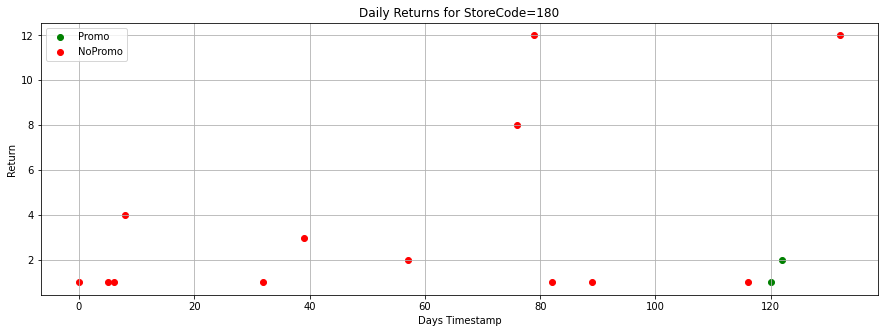

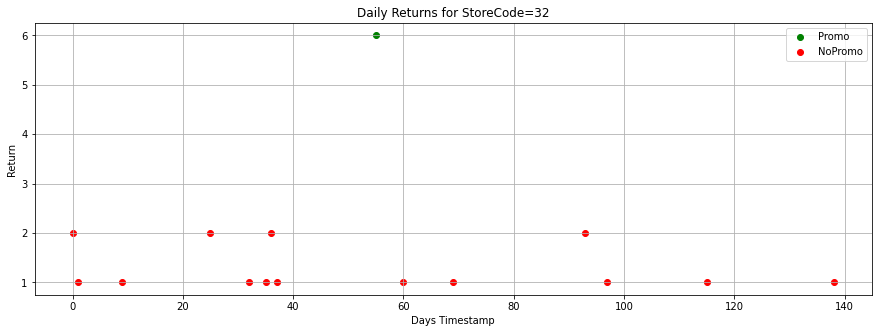

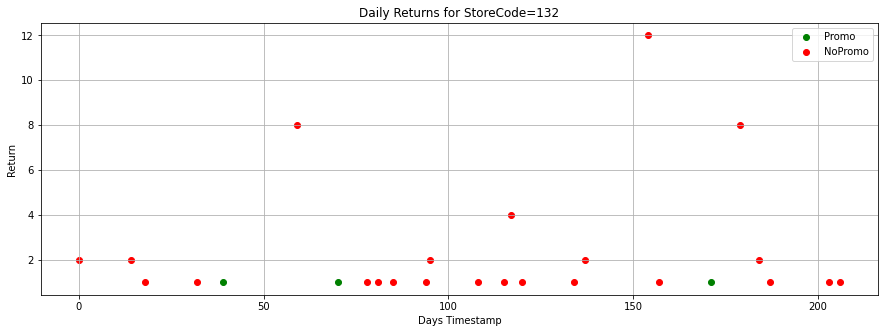

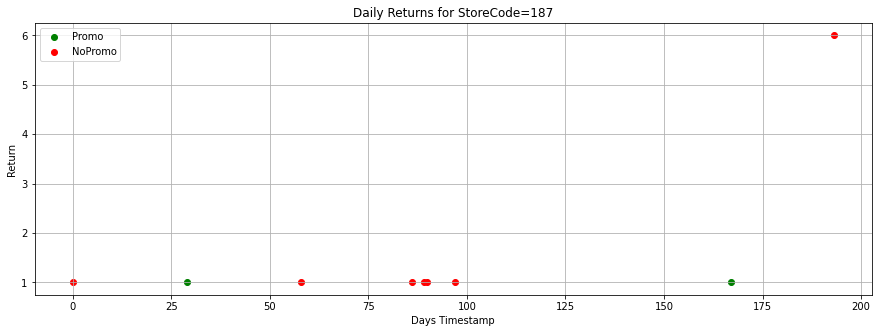

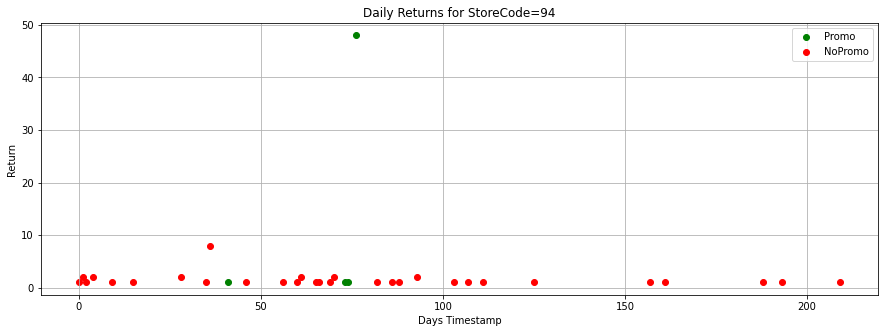

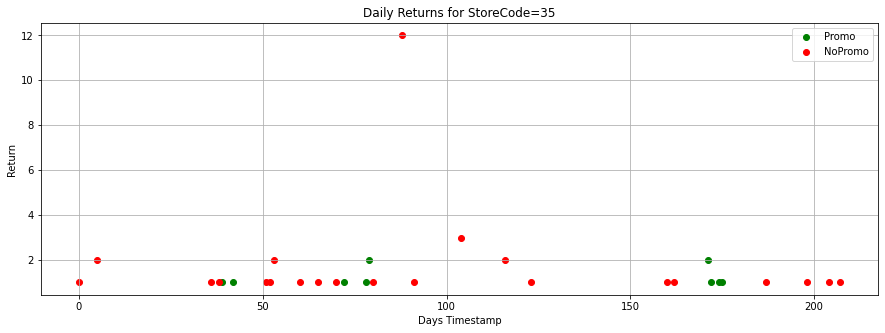

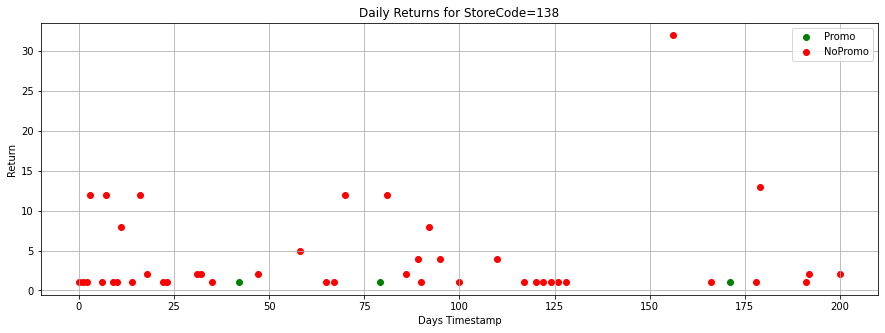

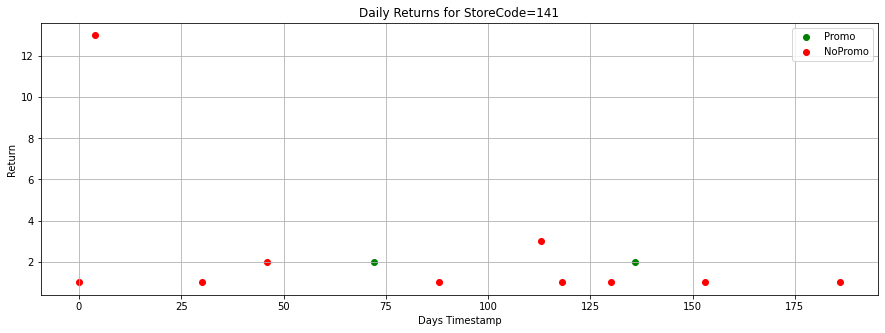

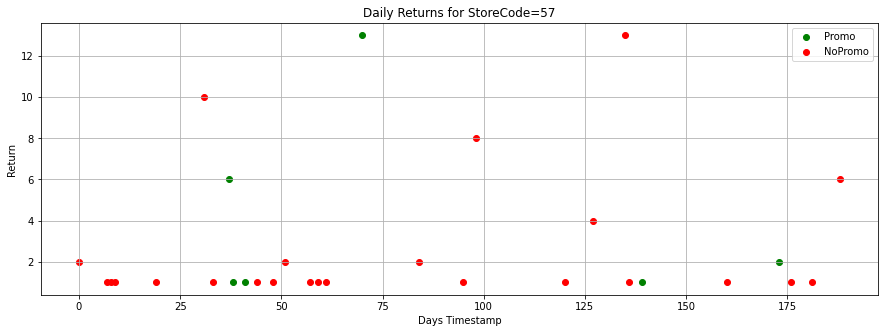

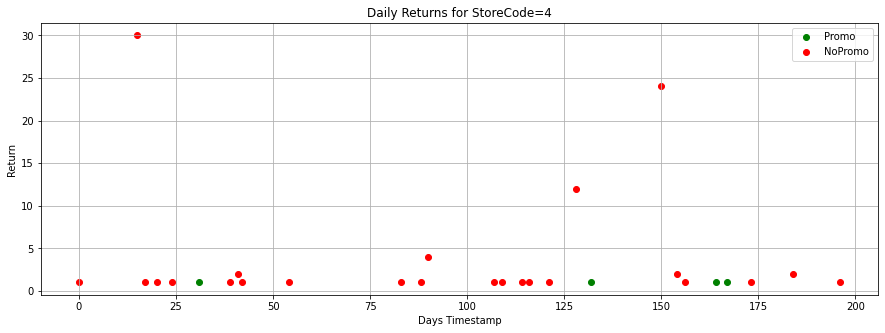

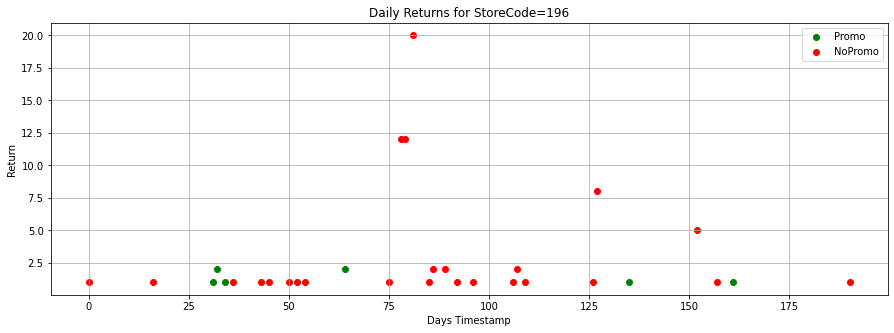

In [20]:
x=random.randint(200, size=(20))
for i in x:
    plot_store_returns(returns,i)

In [21]:
store_8 = daily_sales_data[daily_sales_data['StoreCode']==8]
df1 = store_8.groupby(pd.Grouper(freq='D', key='Date'))['SalesQuantity'].sum()
df1 = pd.DataFrame({'Date':df1.index, 'Satis':df1.values}) #groupby array veriyor kodda onu df yapıyorum.
daily_grouped_promos = [get_promo_type2(path, a) for path in df1['Date'].values]

df1

,Date,Satis
0,2015-01-01,4
1,2015-01-02,51
2,2015-01-03,53
3,2015-01-04,12
4,2015-01-05,50
...,...,...
207,2015-07-27,111
208,2015-07-28,39
209,2015-07-29,59
210,2015-07-30,53


In [22]:
store_8_returns = returns[returns['StoreCode']==8]
df1_returns = store_8_returns.groupby(pd.Grouper(freq='D', key='Date'))['SalesQuantity'].sum()
df1_returns = pd.DataFrame({'Date':df1_returns.index, 'Satis':df1_returns.values})
daily_grouped_promos_returns = [get_promo_type2(path, a) for path in df1_returns['Date'].values]
len(daily_grouped_promos_returns)
df1_returns

,Date,Satis
0,2015-01-01,-1
1,2015-01-02,0
2,2015-01-03,0
3,2015-01-04,0
4,2015-01-05,0
...,...,...
202,2015-07-22,0
203,2015-07-23,0
204,2015-07-24,-1
205,2015-07-25,0


In [23]:
sorted_ = store_8.sort_values(by=['Date'], ascending=True)

sorted_returns = store_8_returns.sort_values(by=['Date'], ascending=True)
sorted_returns

,Date,StoreCode,ProductCode,SalesQuantity,promotion_type
0,2015-01-01,8,9,-1,0
263968,2015-01-07,8,70,-10,0
1760310,2015-01-27,8,293,-1,0
1689295,2015-01-29,8,256,-1,0
1580911,2015-02-02,8,257,-1,0
1356097,2015-02-02,8,232,-1,0
51586,2015-02-06,8,32,-1,0
1719841,2015-02-19,8,288,-1,0
994152,2015-03-02,8,155,-1,0
1831804,2015-03-03,8,305,-2,0


In [24]:
df1["promotion_type"] = daily_grouped_promos
df1_returns["promotion_type"] = daily_grouped_promos_returns
data=df1

In [25]:
df1['timestamp'] = df1['Date'].apply(lambda x: int(time.mktime(x.date().timetuple())))
df1_returns['timestamp'] = df1_returns['Date'].apply(lambda x: int(time.mktime(x.date().timetuple())))
df1_returns['Satis'] = df1_returns['Satis'].apply(lambda x: -x)
df1_returns


df1['timestamp'] = [i for i in range(len(df1))]

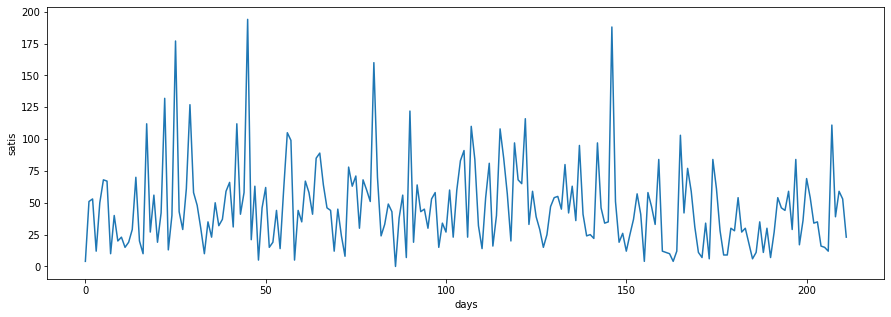

In [26]:
# store 8in satışları burada df1 store 8 e ait olan grplanmış veriler. 
satislar = df1["Satis"].values
fig = plt.figure(figsize=(15, 5))
dates = [i for i in range(len(df1))]
plt.plot(dates, satislar)
plt.xlabel('days')
plt.ylabel('satis')
plt.show()

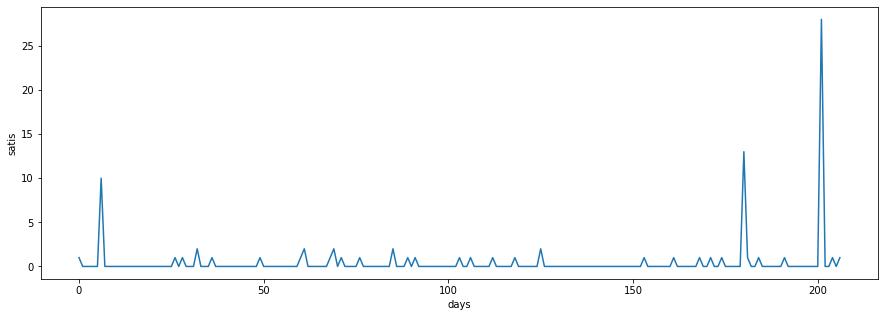

In [27]:
satislar = df1_returns["Satis"].values
fig = plt.figure(figsize=(15, 5))
dates = [i for i in range(len(df1_returns))]
plt.plot(dates, satislar)
plt.xlabel('days')
plt.ylabel('satis')
plt.show()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 127 samples, validate on 32 samples
Epoch 1/200
127/127 [==============================] - 0s 973us/sample - loss: 3491.9599 - mean_squared_error: 3491.9600 - mean_absolute_error: 47.6997 - val_loss: 3098.7241 - val_mean_squared_error: 3098.7241 - val_mean_absolute_error: 48.6712
Epoch 2/200
127/127 [==============================] - 0s 63us/sample - loss: 3489.9516 - mean_squared_error: 3489.9517 - mean_absolute_error: 47.6788 - val_loss: 3096.8799 - val_mean_squared_error: 3096.8799 - val_mean_absolute_error: 48.6523
Epoch 3/200
127/127 [==============================] - 0s 71us/sample - loss: 3487.9039 - mean_squared_error: 3487.9038 - mean_absolute_error: 47.6585 - val_loss: 3094.6982 - val_mean_squared_error: 3094.6982 - val_mean_absolute_error: 48.6297
Epoch 4/200
127/127 [==

127/127 [==============================] - 0s 63us/sample - loss: 2588.1596 - mean_squared_error: 2588.1594 - mean_absolute_error: 37.8831 - val_loss: 2137.7734 - val_mean_squared_error: 2137.7734 - val_mean_absolute_error: 37.5502
Epoch 32/200
127/127 [==============================] - 0s 63us/sample - loss: 2493.2229 - mean_squared_error: 2493.2229 - mean_absolute_error: 36.8920 - val_loss: 2034.9020 - val_mean_squared_error: 2034.9020 - val_mean_absolute_error: 36.2306
Epoch 33/200
127/127 [==============================] - 0s 79us/sample - loss: 2385.7452 - mean_squared_error: 2385.7451 - mean_absolute_error: 35.7952 - val_loss: 1929.9011 - val_mean_squared_error: 1929.9011 - val_mean_absolute_error: 34.8414
Epoch 34/200
127/127 [==============================] - 0s 71us/sample - loss: 2286.9273 - mean_squared_error: 2286.9272 - mean_absolute_error: 34.7543 - val_loss: 1820.0950 - val_mean_squared_error: 1820.0950 - val_mean_absolute_error: 33.3962
Epoch 35/200
127/127 [===========

Epoch 65/200
127/127 [==============================] - 0s 71us/sample - loss: 1316.7585 - mean_squared_error: 1316.7585 - mean_absolute_error: 26.7286 - val_loss: 815.1537 - val_mean_squared_error: 815.1537 - val_mean_absolute_error: 22.0844
Epoch 66/200
127/127 [==============================] - 0s 63us/sample - loss: 1315.5123 - mean_squared_error: 1315.5123 - mean_absolute_error: 26.7126 - val_loss: 814.0521 - val_mean_squared_error: 814.0521 - val_mean_absolute_error: 22.0700
Epoch 67/200
127/127 [==============================] - 0s 63us/sample - loss: 1314.1608 - mean_squared_error: 1314.1608 - mean_absolute_error: 26.7041 - val_loss: 812.6384 - val_mean_squared_error: 812.6384 - val_mean_absolute_error: 22.0552
Epoch 68/200
127/127 [==============================] - 0s 55us/sample - loss: 1312.1573 - mean_squared_error: 1312.1573 - mean_absolute_error: 26.6881 - val_loss: 811.0929 - val_mean_squared_error: 811.0929 - val_mean_absolute_error: 22.0354
Epoch 69/200
127/127 [======

Epoch 99/200
127/127 [==============================] - 0s 63us/sample - loss: 1272.7620 - mean_squared_error: 1272.7620 - mean_absolute_error: 26.3673 - val_loss: 774.1620 - val_mean_squared_error: 774.1620 - val_mean_absolute_error: 21.4799
Epoch 100/200
127/127 [==============================] - 0s 63us/sample - loss: 1271.6643 - mean_squared_error: 1271.6644 - mean_absolute_error: 26.3592 - val_loss: 773.6110 - val_mean_squared_error: 773.6110 - val_mean_absolute_error: 21.4646
Epoch 101/200
127/127 [==============================] - 0s 71us/sample - loss: 1270.5324 - mean_squared_error: 1270.5323 - mean_absolute_error: 26.3426 - val_loss: 772.7593 - val_mean_squared_error: 772.7593 - val_mean_absolute_error: 21.4481
Epoch 102/200
127/127 [==============================] - 0s 71us/sample - loss: 1269.5211 - mean_squared_error: 1269.5210 - mean_absolute_error: 26.3312 - val_loss: 771.5302 - val_mean_squared_error: 771.5302 - val_mean_absolute_error: 21.4270
Epoch 103/200
127/127 [==

127/127 [==============================] - 0s 63us/sample - loss: 1241.1694 - mean_squared_error: 1241.1694 - mean_absolute_error: 26.1008 - val_loss: 744.4528 - val_mean_squared_error: 744.4528 - val_mean_absolute_error: 20.9161
Epoch 133/200
127/127 [==============================] - 0s 63us/sample - loss: 1241.1063 - mean_squared_error: 1241.1063 - mean_absolute_error: 26.0942 - val_loss: 744.2341 - val_mean_squared_error: 744.2341 - val_mean_absolute_error: 20.9042
Epoch 134/200
127/127 [==============================] - 0s 63us/sample - loss: 1239.6140 - mean_squared_error: 1239.6139 - mean_absolute_error: 26.0793 - val_loss: 743.1277 - val_mean_squared_error: 743.1277 - val_mean_absolute_error: 20.8925
Epoch 135/200
127/127 [==============================] - 0s 63us/sample - loss: 1239.5030 - mean_squared_error: 1239.5031 - mean_absolute_error: 26.0853 - val_loss: 742.5364 - val_mean_squared_error: 742.5364 - val_mean_absolute_error: 20.8773
Epoch 136/200
127/127 [===============

Epoch 166/200
127/127 [==============================] - 0s 71us/sample - loss: 1219.1728 - mean_squared_error: 1219.1727 - mean_absolute_error: 25.9884 - val_loss: 720.4490 - val_mean_squared_error: 720.4490 - val_mean_absolute_error: 20.4993
Epoch 167/200
127/127 [==============================] - 0s 63us/sample - loss: 1219.2405 - mean_squared_error: 1219.2405 - mean_absolute_error: 25.9894 - val_loss: 721.0113 - val_mean_squared_error: 721.0113 - val_mean_absolute_error: 20.4748
Epoch 168/200
127/127 [==============================] - 0s 64us/sample - loss: 1217.3538 - mean_squared_error: 1217.3539 - mean_absolute_error: 25.9552 - val_loss: 720.2803 - val_mean_squared_error: 720.2803 - val_mean_absolute_error: 20.4674
Epoch 169/200
127/127 [==============================] - 0s 71us/sample - loss: 1216.9498 - mean_squared_error: 1216.9498 - mean_absolute_error: 25.9494 - val_loss: 720.0731 - val_mean_squared_error: 720.0731 - val_mean_absolute_error: 20.4552
Epoch 170/200
127/127 [=

127/127 [==============================] - 0s 63us/sample - loss: 1204.0920 - mean_squared_error: 1204.0920 - mean_absolute_error: 25.8547 - val_loss: 707.5800 - val_mean_squared_error: 707.5800 - val_mean_absolute_error: 20.2507
Epoch 200/200
127/127 [==============================] - 0s 71us/sample - loss: 1203.7069 - mean_squared_error: 1203.7068 - mean_absolute_error: 25.8346 - val_loss: 707.4313 - val_mean_squared_error: 707.4313 - val_mean_absolute_error: 20.2441
[[ 41]
 [ 46]
 [ 23]
 [ 42]
 [ 26]
 [ 51]
 [ 60]
 [ 68]
 [ 54]
 [ 39]
 [ 32]
 [188]
 [ 69]
 [ 34]
 [ 27]
 [ 33]
 [ 43]
 [ 15]
 [ 32]
 [ 44]
 [ 13]
 [ 61]
 [ 10]
 [ 85]
 [  7]
 [ 68]
 [ 27]
 [ 12]
 [ 61]
 [ 11]
 [ 27]
 [ 16]
 [ 47]
 [ 35]
 [  6]
 [  9]
 [ 43]
 [ 15]
 [ 21]
 [ 17]
 [ 14]
 [ 59]
 [ 41]
 [116]
 [  0]
 [ 68]
 [ 12]
 [ 58]
 [ 45]
 [112]
 [ 70]
 [ 89]
 [ 20]] [[45.385677]
 [55.89426 ]
 [46.39701 ]
 [45.110756]
 [55.835354]
 [55.854992]
 [45.729336]
 [46.69157 ]
 [44.85547 ]
 [45.513325]
 [45.67042 ]
 [55.86481 

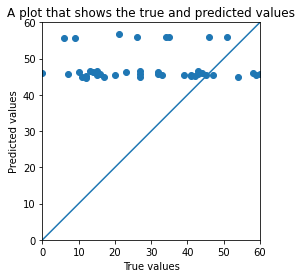

In [28]:
history = construct_and_train_model("StoreCode","D",daily_sales_data,8)

NameError: name 'model' is not defined

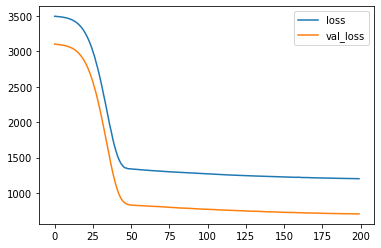

In [29]:
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')

plt.legend()

y_pred = model.predict(data_x_test).flatten()

In [30]:
#bonus soru cevap paired test. promosyonların returnlere etkisi
#x=random.randint(200, size=(20))
x=random.randint(200, size=(500))
for product_code in x:
    products_filtered = returns[returns['ProductCode']==product_code]

    grouped = products_filtered.groupby(pd.Grouper(freq='D', key='Date'))['SalesQuantity'].sum()
    product_grouped_returns = pd.DataFrame({'Date':grouped.index, 'Return':grouped.values, 'Product':[product_code]*len(grouped.values)})

    product_grouped_returns = product_grouped_returns[product_grouped_returns["Return"]<0]

    product_grouped_returns['Return'] = product_grouped_returns['Return'].apply(lambda x: -x)

    daily_grouped_promos = [get_promo_type2(path, a) for path in product_grouped_returns['Date'].values]
    product_grouped_returns["promotion_type"] = daily_grouped_promos


    promo_returns = product_grouped_returns[product_grouped_returns["promotion_type"]=='1']
    no_promo_returns = product_grouped_returns[product_grouped_returns["promotion_type"]=='0']

    sample1 = promo_returns["Return"].tolist()
    sample2 = no_promo_returns["Return"].tolist()
    #if len(sample1)>10 and len(sample2)>10:
    if len(sample1)>20 and len(sample2)>20:
        print(sample1,sample2)
        print("ProductCode:{} {}".format(product_code,ttest_rel(sample1,sample(sample2,len(sample1)))))



[2, 1, 1, 1, 2, 1, 2, 3, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 5] [1, 1, 1, 4, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 2, 2, 2, 1, 2, 1, 1, 3, 1, 2, 1, 1, 3, 2, 1, 7, 2, 1, 2, 2, 2, 4, 2, 3, 6, 2, 1, 4, 2, 6, 3, 3, 6, 3, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 3, 3, 3, 1, 1, 1, 1, 2, 5, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 2, 3, 1, 2, 2, 1, 1, 1, 2, 3, 2, 4, 1, 1, 3, 4, 1, 5, 1, 2, 1, 3, 1, 3]
ProductCode:176 Ttest_relResult(statistic=-0.847998304005088, pvalue=0.404817147164677)
[1, 1, 1, 2, 2, 1, 3, 1, 5, 1, 2, 1, 3, 1, 3, 1, 2, 2, 1, 1, 2] [3, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 2, 1, 1, 2, 1, 2, 1]
ProductCode:175 Ttest_relResult(statistic=1.1281521496355325, pvalue=0.2726077507799729)
[2, 1, 1, 1, 2, 1, 2, 3, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 5] [1, 1, 1, 4, 1

In [31]:
'''null = promosyonlar retunler üzerinde etkisizdir. 
H = promosyonların returnler üzerinde güçlü bir etkisi vardır. 
Because our p-values are greater than the standard significance level of 0.05, we cannot reject the null hypothesis
so , promosyonların returnler üzerinde etkisi yoktur.'''


'null = promosyonlar retunler üzerinde etkisizdir. \nH = promosyonların returnler üzerinde güçlü bir etkisi vardır. \nBecause our p-values are greater than the standard significance level of 0.05, we cannot reject the null hypothesis\nso , promosyonların returnler üzerinde etkisi yoktur.'